In [1]:
#Imports some of the libraries that we will be using
import pandas as pd
import numpy as np
import math
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import metrics
from sklearn import tree
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')


In [2]:
from load_dataset import load
from classifier import NeuralNetwork, Logistic_Regression, SVM
from utils import *
from metrics import *  # include fairness and corresponding derivatives
from expl import explanation_candidate_generation, get_top_k_expl
from influence import *

['classifier.py', 'compas-scores-two-years.csv', 'compas_if.ipynb', 'config.json', 'expl.py', 'functions.py', 'german.data', 'influence.py', 'influence_functions.ipynb', 'influence_functions_copy.ipynb', 'load_dataset.py', 'loss.py', 'metrics.py', 'utils.py', '__pycache__']


<h4>Build model and get teh influence points<h4>

In [3]:
dataset = 'german'
clf_name = 'Logistic_Regression'
metric = 0
support = 0.05
support_small = 0.3

In [4]:
X_train, X_test, y_train, y_test = load(dataset)

In [5]:
duplicates = 1
make_duplicates = lambda x, d: pd.concat([x]*d, axis=0).reset_index(drop=True)
X_train = make_duplicates(X_train, duplicates)
X_test = make_duplicates(X_test, duplicates)
y_train = make_duplicates(y_train, duplicates)
y_test = make_duplicates(y_test, duplicates)

In [6]:
len(X_train)

800

In [7]:
import copy
X_train_orig = copy.deepcopy(X_train)
X_test_orig = copy.deepcopy(X_test)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [8]:
clf = eval(clf_name)(input_size=X_train.shape[-1])

num_params = len(convert_grad_to_ndarray(list(clf.parameters())))
if isinstance(clf, Logistic_Regression):
    loss_func = logistic_loss_torch
elif isinstance(clf, SVM):
    loss_func = svm_loss_torch
elif isinstance(clf, NeuralNetwork):
    loss_func = nn_loss_torch
else:
    raise NotImplementedError

In [9]:
clf = eval(clf_name)(input_size=X_train.shape[-1])

clf.fit(X_train, y_train)

y_pred_test = clf.predict_proba(X_test)
y_pred_train = clf.predict_proba(X_train)

spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
print("Initial statistical parity: ", spd_0)

tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
print("Initial TPR parity: ", tpr_parity_0)

predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
print("Initial predictive parity: ", predictive_parity_0)

accuracy_0 = computeAccuracy(y_test, y_pred_test)
print("Initial accuracy: ", accuracy_0)

Initial statistical parity:  -0.09527579839341338
Initial TPR parity:  -0.07785149414194836
Initial predictive parity:  -0.10136869475949661
Initial accuracy:  0.755


<h4>Calculate Influence of original datapoints with original labels<h4>

In [10]:
metric_val = [spd_0, tpr_parity_0, predictive_parity_0][metric]
del_F_del_theta = get_del_F_del_theta(clf, X_test_orig, X_test, y_test, dataset, metric)

In [11]:
hessian_all_points = get_hessian_all_points(clf, X_train, y_train, loss_func)

100%|██████████| 800/800 [00:12<00:00, 64.27it/s]


In [12]:
del_L_del_theta = get_del_L_del_theta(clf, X_train, y_train, loss_func)

In [13]:
hinv_v, hinv = get_hinv_v(hessian_all_points, np.transpose(del_L_del_theta))
#incorporate del_l_del_theta_i with the updated datapoint

In [14]:
inf = np.matmul(np.transpose(hinv_v), del_F_del_theta)
#For the new datapoint re-calculate the hinv_v

In [15]:
inf=(1/len(X_train))*(inf)

In [16]:
print(min(inf))
print(max(inf))

-0.005975094170870934
0.003204487974823138


<h4>Calculate the inf for the datapoints with a changed label using del_L_del_theta_i<h4>

In [17]:
#Use the same info from the previous section but with the labels changed
#Original Four datasets
X_test#scaled
X_train#scaled
X_test_orig#encoded
X_test_orig#encoded

,status,duration,credit_hist,credit_amt,savings,employment,install_rate,debtors,residence,property,...,purpose_A42,purpose_A43,purpose_A44,purpose_A45,purpose_A46,purpose_A48,purpose_A49,housing_A151,housing_A152,housing_A153
0,1,1,3,2,1,0,1,0,2,2,...,False,False,False,False,False,False,False,False,True,False
1,0,2,2,2,0,0,2,1,3,1,...,False,False,False,False,False,False,False,False,True,False
2,3,0,4,1,0,4,2,0,4,2,...,True,False,False,False,False,False,False,False,True,False
3,0,2,2,1,0,4,4,0,2,1,...,True,False,False,False,False,False,False,False,True,False
4,0,3,4,1,0,4,3,0,4,0,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,3,0,2,1,0,3,1,0,4,3,...,False,False,False,False,False,False,True,False,True,False
196,0,0,2,1,0,2,2,1,2,2,...,True,False,False,False,False,False,False,False,True,False
197,3,0,0,0,4,3,4,0,4,3,...,False,False,False,True,False,False,False,False,True,False
198,3,1,2,1,0,1,4,0,1,3,...,False,True,False,False,False,False,False,False,True,False


In [18]:
#Flip all the labels for the encoded data and the scaled data
#The labels are the same just the training data looks different 
y_train_changed = y_train.replace({0:1,1:0})
y_test_changed = y_test.replace({0:1,1:0})

In [19]:
#Instead of flipping everything before iteratively move through the dataset and calculate del_L_del_i


In [20]:
#Run the Classifiers and calculate the statistical parity after changing everything
#In theory it shouldnt change anything but uhhhh lets see 
clf = eval(clf_name)(input_size=X_train.shape[-1])

num_params = len(convert_grad_to_ndarray(list(clf.parameters())))
if isinstance(clf, Logistic_Regression):
    loss_func = logistic_loss_torch
elif isinstance(clf, SVM):
    loss_func = svm_loss_torch
elif isinstance(clf, NeuralNetwork):
    loss_func = nn_loss_torch
else:
    raise NotImplementedError

In [21]:
clf = eval(clf_name)(input_size=X_train.shape[-1])

clf.fit(X_train, y_train_changed)

y_pred_test = clf.predict_proba(X_test)
y_pred_train = clf.predict_proba(X_train)

spd_1 = computeFairness(y_pred_test, X_test_orig, y_test_changed, 0, dataset)
print("Initial statistical parity: ", spd_1)

tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test_changed, 1, dataset)
print("Initial TPR parity: ", tpr_parity_0)

predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test_changed, 2, dataset)
print("Initial predictive parity: ", predictive_parity_0)

accuracy_0 = computeAccuracy(y_test_changed, y_pred_test)
print("Initial accuracy: ", accuracy_0)

Initial statistical parity:  0.09501853685360401
Initial TPR parity:  0.06228146450046229
Initial predictive parity:  0.10818301552416582
Initial accuracy:  0.755


In [22]:
metric_val = [spd_0, tpr_parity_0, predictive_parity_0][metric]
del_F_del_theta = get_del_F_del_theta(clf, X_test_orig, X_test, y_test_changed, dataset, metric)

In [23]:
# Convert numpy array to tensorflow tensor
import torch 
tensor_train_attr = torch.Tensor(X_train)
tensor_train_label = torch.Tensor(y_train_changed)

In [24]:
tensor_train_label = tensor_train_label.type(torch.float64)
tensor_train_attr = tensor_train_attr.type(torch.float64)

In [25]:
del_L_del_i = []
for i in range(int(len(X_train))):
    gradient = convert_grad_to_ndarray(del_L_del_theta_i(clf, X_train[i], int(y_train_changed[i]), loss_func))
    del_L_del_i.append(gradient)

In [26]:
del_L_del_i = np.array(del_L_del_i)

In [27]:
hessian_all_points = get_hessian_all_points(clf, X_train, y_train_changed, loss_func)

100%|██████████| 800/800 [00:12<00:00, 63.42it/s]


In [28]:
del_L_del_theta = get_del_L_del_theta(clf, X_train, y_train_changed, loss_func)

In [29]:
hinv_v, hinv = get_hinv_v(hessian_all_points, np.transpose(del_L_del_i))
#incorporate del_l_del_theta_i with the updated datapoint

In [30]:
inf2 = np.matmul(np.transpose(hinv_v), del_F_del_theta)
#For the new datapoint re-calculate the hinv_v

In [31]:
inf2 = (1/len(X_train))*(inf2)

In [32]:
print(min(inf2))
print(max(inf2))

-0.003213448287634082
0.005969755902279662


<h4>Calculate the inf for the datapoints with the changed label using the original method<h4>

In [33]:
metric_val = [spd_0, tpr_parity_0, predictive_parity_0][metric]
del_F_del_theta = get_del_F_del_theta(clf, X_test_orig, X_test, y_test_changed, dataset, metric)

In [34]:
hessian_all_points = get_hessian_all_points(clf, X_train, y_train_changed, loss_func)

100%|██████████| 800/800 [00:12<00:00, 63.26it/s]


In [35]:
del_L_del_theta = get_del_L_del_theta(clf, X_train, y_train_changed, loss_func)

In [36]:
hinv_v, hinv = get_hinv_v(hessian_all_points, np.transpose(del_L_del_theta))

In [37]:
inf3 = np.matmul(np.transpose(hinv_v), del_F_del_theta)

In [38]:
inf3 = (1/len(X_train))*(inf3)

In [39]:
print(min(inf3))
print(max(inf3))

-0.003213448287634082
0.005969755902279662


In [40]:
#Check to see if the influences are correct by graphing the predicted vs the actual fairness similar to the paper
    #Check this for the OG datapoints not the changed labels
#Also make a cleaner version of this notebook for dr. pradhan to check
    #Keep just information about the influence functions and removing datapoints rather than information about flipping 
    #Take a copy and make the changes
#Use computeFairness() for testing for parity

<h4>Calculate the difference between the changed vs original<h4>

In [41]:
total_inf = inf2-inf

In [42]:
print(max(total_inf))
print(min(total_inf))
print(len(total_inf))
print(type(total_inf))
print(total_inf.dtype)

0.011944850073150597
-0.00641793626245722
800
<class 'numpy.ndarray'>
float64


<h4>Flip the datapoints and remove the datapoints and compare the parity values<h4>

In [43]:
predictors = ['status', 'duration', 'credit_hist', 'credit_amt', 'savings',
       'employment', 'install_rate', 'debtors', 'residence', 'property', 'age',
       'install_plans', 'num_credits', 'job', 'num_liable', 'telephone',
       'foreign_worker', 'gender', 'purpose_A40', 'purpose_A41',
       'purpose_A410', 'purpose_A42', 'purpose_A43', 'purpose_A44',
       'purpose_A45', 'purpose_A46', 'purpose_A48', 'purpose_A49',
       'housing_A151', 'housing_A152', 'housing_A153']
target_var =['credit_risk']

In [44]:
#Function to run the logistic regression model based on classifier.py
def lr_model(training_df, test_attr_df, classifier):
    changed_df_labels = training_df.pop('credit_risk')
    changed_df_attr = training_df.to_numpy()

    classifier.fit(changed_df_attr,changed_df_labels.values)
    y_predicted = classifier.predict_proba(test_attr_df)

    training_df['credit_risk'] = changed_df_labels

    return y_predicted


In [45]:
#Combine x_train and y_train
#I combine these so that when I flip the labels I have one DF that I work with
#Rather than 2 numpy.ndarrays
train_demo_df = pd.DataFrame(X_train, columns = predictors)
train_outcome_df = y_train.to_frame()
train_outcome_df=train_outcome_df.rename(columns={'credit':'credit_risk'})
train_full_df = pd.concat([train_demo_df, train_outcome_df], axis=1)

In [46]:
copy_train = train_full_df.copy()
difference = []

for index in copy_train.index:
    df_dropped = copy_train.copy()
    df_dropped = copy_train.drop(index)
    #Run lr_model() to get predicted probabilities
    ypred = lr_model(df_dropped, X_test, clf)
    parity = computeFairness(ypred, X_test_orig, y_test, 0, dataset)
    
    parity = parity-spd_0

    difference.append(parity)
    print(parity)


-0.0003127523697913359
0.001229622634127625
0.00044726314954457447
-4.2051402851961406e-05
0.0009012660942971928
0.00043631773442032173
0.00037643443793056175
0.0003076293505728245
-0.0008628592826426251
0.001044456008821748
0.00013030185364182323
0.0005219595041126013
-0.0007302274461835623
-0.0016043717972934468
0.0014366827905177848
0.001417352259159066
0.0010786592960356778
0.0013204716145992501
-0.0011724349111318366
0.00015916121192272037
-0.0006672131828964201
-0.00036165560595702306
0.000811280682682991
4.382957704363033e-05
-0.00037126871757220403
0.0012898824643342577
-0.0003633903805166927
0.001382103795185663
-0.00035963081754752935
0.00025239069946103587
0.0005662188399582213
-0.00012731999158865914
0.000297734467312627
0.001941060787066795
-0.00044487561099237904
0.000297134183347203
-5.441461689781324e-05
0.0016401637345552222
0.0012618583627044266
0.00026418250054116577
0.0009184890892356412
0.00039731431752443314
0.001747675612568722
0.0012534052599221246
0.00050160889

In [47]:
print(difference)

[-0.0003127523697913359, 0.001229622634127625, 0.00044726314954457447, -4.2051402851961406e-05, 0.0009012660942971928, 0.00043631773442032173, 0.00037643443793056175, 0.0003076293505728245, -0.0008628592826426251, 0.001044456008821748, 0.00013030185364182323, 0.0005219595041126013, -0.0007302274461835623, -0.0016043717972934468, 0.0014366827905177848, 0.001417352259159066, 0.0010786592960356778, 0.0013204716145992501, -0.0011724349111318366, 0.00015916121192272037, -0.0006672131828964201, -0.00036165560595702306, 0.000811280682682991, 4.382957704363033e-05, -0.00037126871757220403, 0.0012898824643342577, -0.0003633903805166927, 0.001382103795185663, -0.00035963081754752935, 0.00025239069946103587, 0.0005662188399582213, -0.00012731999158865914, 0.000297734467312627, 0.001941060787066795, -0.00044487561099237904, 0.000297134183347203, -5.441461689781324e-05, 0.0016401637345552222, 0.0012618583627044266, 0.00026418250054116577, 0.0009184890892356412, 0.00039731431752443314, 0.00174767561

In [48]:
spd_0

-0.09527579839341338

In [49]:
decimal_array = [format(num, '.10f') for num in inf]
decimal_array = [float(num) for num in decimal_array]
print(decimal_array)

[-0.0001350161, 0.0007689151, 1.468e-06, -0.0004601497, 0.0004579974, -1.5055e-06, -6.41949e-05, -0.0001304815, -0.0012377489, 0.0005813503, -0.0002946993, 7.63424e-05, -0.0011414374, -0.001858289, 0.0009743028, 0.0009411389, 0.0006241242, 0.0008615548, -0.0015670895, -0.000278972, -0.0010752921, -0.0007589532, 0.0003648374, -0.0003838773, -0.0006934423, 0.0008288297, -0.0007814517, 0.0009263216, -0.0007694597, -0.0001842594, 0.0001243821, -0.0005587321, -0.0001397267, 0.0014771749, -0.0008536602, -0.0001388449, -0.0004821032, 0.0011374723, 0.0008044177, -0.0001802059, 0.0004345539, -3.75049e-05, 0.0012635428, 0.0007711644, 6.91594e-05, -0.0001815898, -0.0013354056, 0.0012204247, 7.2261e-06, -6.62973e-05, -0.0002172353, -6.24262e-05, -0.0029064492, -0.0013223234, -0.0006591325, -0.000135914, -0.0003290167, 0.0011758743, -0.00065706, -0.0002498615, -7.13334e-05, -6.9873e-05, 0.0004087943, 0.0003963535, 0.0009018029, -6.7238e-06, -0.0010662154, -0.0003458889, -4.15909e-05, -0.0001205018,

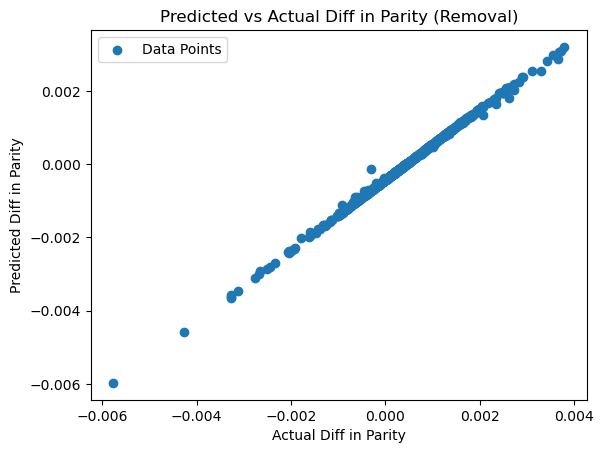

In [50]:
# Assuming your lists are named `predicted_diff` and `actual_diff`
predicted_diff = decimal_array
actual_diff = difference

# Create the scatter plot
plt.scatter(actual_diff, predicted_diff, label='Data Points')

# Set the labels for the axes
plt.xlabel('Actual Diff in Parity')
plt.ylabel('Predicted Diff in Parity')

# Set the title of the plot (optional)
plt.title('Predicted vs Actual Diff in Parity (Removal)')

# Add a legend
plt.legend()

# Show the plot
plt.show()

<h3>##########################################################################################<h3>

<h4>Make flips based on the total_inf value<h4>

In [51]:
index_list = []
for i in range(800):
    index_list.append(i)


In [52]:
#Make a copy of the training data to make flips on 
influence_train_copy = train_full_df.copy()

In [53]:
#Order the total_inf in descending order based on magnitude
combined_list = list(zip(total_inf, index_list))

# Step 2: Sort the combined list based on the float values
sorted_combined_list = sorted(combined_list, key=lambda x: abs(x[0]), reverse=True)

# Step 3: Unpack the sorted list of tuples back into two separate lists
abs_sorted_float_list, abs_sorted_index_list = zip(*sorted_combined_list)
list(abs_sorted_float_list)
list(abs_sorted_index_list)

[198,
 423,
 597,
 690,
 553,
 652,
 342,
 506,
 429,
 636,
 770,
 252,
 52,
 376,
 350,
 374,
 405,
 161,
 796,
 349,
 386,
 289,
 233,
 241,
 739,
 231,
 89,
 398,
 620,
 196,
 354,
 598,
 330,
 608,
 266,
 430,
 732,
 238,
 547,
 202,
 626,
 792,
 505,
 390,
 428,
 508,
 13,
 371,
 524,
 694,
 104,
 242,
 542,
 444,
 473,
 487,
 695,
 716,
 697,
 80,
 757,
 462,
 469,
 163,
 18,
 175,
 475,
 239,
 338,
 378,
 737,
 133,
 33,
 701,
 265,
 215,
 412,
 672,
 479,
 112,
 230,
 344,
 185,
 328,
 76,
 772,
 268,
 247,
 530,
 301,
 46,
 771,
 122,
 282,
 353,
 748,
 53,
 319,
 359,
 671,
 522,
 287,
 146,
 610,
 129,
 567,
 42,
 356,
 725,
 526,
 367,
 8,
 552,
 167,
 47,
 130,
 296,
 696,
 275,
 232,
 503,
 432,
 57,
 102,
 326,
 680,
 298,
 604,
 668,
 586,
 12,
 37,
 272,
 292,
 682,
 120,
 83,
 675,
 340,
 98,
 740,
 588,
 618,
 20,
 333,
 66,
 116,
 224,
 632,
 450,
 639,
 192,
 778,
 661,
 126,
 313,
 585,
 470,
 134,
 720,
 640,
 691,
 744,
 314,
 537,
 14,
 782,
 548,
 595,
 556,
 

In [54]:
flip_parity_abs = []
for i in range(len(abs_sorted_index_list)):
    row_num = abs_sorted_index_list[i]
    if influence_train_copy.at[row_num,'credit_risk'] == 1:
        influence_train_copy.at[row_num,'credit_risk'] = 0
        influence_prediction = lr_model(influence_train_copy, X_test, clf)
        influence_parity = computeFairness(influence_prediction, X_test_orig, y_test, 0, dataset)
        flip_parity_abs.append(influence_parity)
    elif influence_train_copy.at[row_num,'credit_risk'] == 0:
        influence_train_copy.at[row_num,'credit_risk'] = 1
        influence_prediction = lr_model(influence_train_copy, X_test, clf)
        influence_parity = computeFairness(influence_prediction, X_test_orig, y_test, 0, dataset)
        flip_parity_abs.append(influence_parity)
print(flip_parity_abs)

[-0.10217929775826629, -0.10753714828751981, -0.11207302613183856, -0.11622928818687794, -0.12125293579883867, -0.12659075665287667, -0.12146632582880557, -0.11644867723807695, -0.12104142778553073, -0.11648934441618619, -0.12095326622948044, -0.11600848110392692, -0.11992156892083583, -0.11489752978086465, -0.1190728436689823, -0.1138976295478642, -0.11768810525536533, -0.1224988899659365, -0.11609310787171123, -0.11294396608136592, -0.11619227537885313, -0.1210963354911655, -0.11697704186663027, -0.11235623923130333, -0.11716358293779194, -0.12069159294478593, -0.12367278970777995, -0.12866318263113496, -0.13226142940111452, -0.12754662926308813, -0.12188710942864411, -0.11724128196947281, -0.1143254173453897, -0.11111117335967713, -0.10591281671077013, -0.1011289143469184, -0.10429659164510663, -0.10836032391525807, -0.10556697850115593, -0.09946359903551638, -0.1039733923971653, -0.10118115977384157, -0.09581840769387773, -0.0916045494843275, -0.08911148435436189, -0.09173081549815

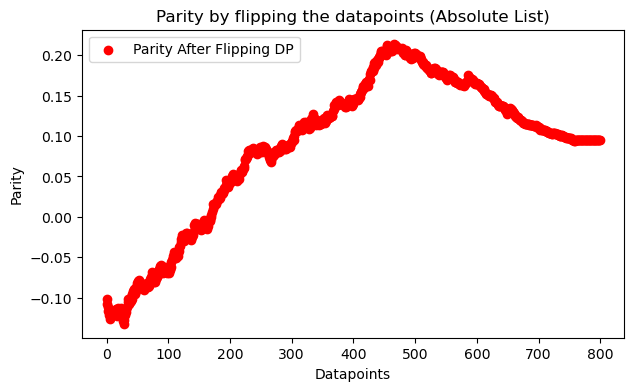

In [55]:
#Graph the points
# Assuming the X-axis is some common range or specific values
size = range(len(flip_parity_abs))  # X values for list data

# Create the plot
plt.figure(figsize=(7, 4))

# Plot list data with dots
plt.scatter(size, flip_parity_abs, color='red', label='Parity After Flipping DP', marker='o')

# Adding labels
plt.xlabel('Datapoints')
plt.ylabel('Parity')

# Adding title and legend
plt.title('Parity by flipping the datapoints (Absolute List)')
plt.legend()

# Display the plot
plt.show()

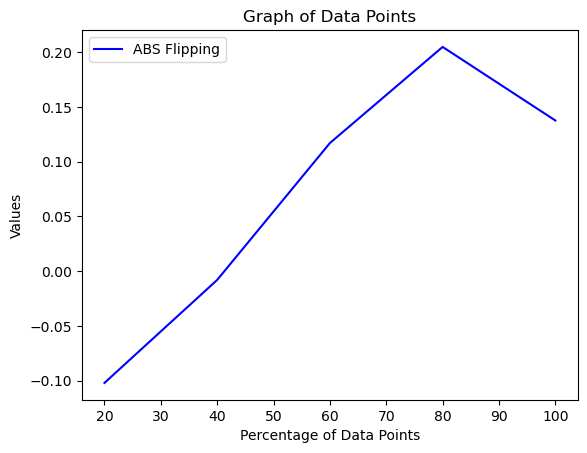

In [56]:
#total num of data points
#on_abs_sorted = len(flip_parity_sorted)
abs_sorted = len(flip_parity_abs)

#Calculate the indices for the 5 points
#indices_non_abs = [int(i * non_abs_sorted / 5) for i in range(0, 5)]
indices_abs = [int(i * abs_sorted / 5) for i in range(0, 5)]

# Extract the values at these indices
#values_non_abs = [flip_parity_sorted[index] for index in indices_non_abs]
values_abs = [flip_parity_abs[index] for index in indices_abs]

#Plot the Values
plt.plot([20, 40, 60, 80, 100], values_abs, label='ABS Flipping', color='Blue')

# Add labels and legend
plt.xlabel('Percentage of Data Points')
plt.ylabel('Values')
plt.title('Graph of Data Points')
plt.legend()

# Show the plot
plt.show()

<h3>Compare methods of: Naive, Entropy, MEU, and IF<h3>

<h5>Naive Method: Greedy Algorithm<h5>

In [57]:
#Beginning of the Greedy Algorithm
#Make the original flips to test for the parity after each flip 
greedy_train = train_full_df.copy()
greedy_parity_list = []

for index, row in greedy_train.iterrows():
    if row['credit_risk'] == 1:
        #Flip the label at credit_risk = 1 to 0
        greedy_train.at[index,'credit_risk'] = 0
        greedy_pred = lr_model(greedy_train, X_test, clf)
        greedy_parity = computeFairness(greedy_pred, X_test_orig, y_test, 0, dataset)
        greedy_parity_list.append(greedy_parity)
        greedy_train.at[index,'credit_risk'] = 1
        
    elif row['credit_risk'] == 0:
        greedy_train.at[index,'credit_risk'] = 1
        greedy_pred = lr_model(greedy_train, X_test, clf)
        greedy_parity = computeFairness(greedy_pred, X_test_orig, y_test, 0, dataset)
        greedy_parity_list.append(greedy_parity)
        greedy_train.at[index,'credit_risk'] = 0

In [58]:
#Compare each of the parity values after flipping to the OG parity value
#Append to a new list

#parity_difference: Contains the difference between flipped and original value
parity_difference = []
#Contains parity values that fall between .03 and -.03
large_influence = []
#Contains the row number of each flip
li_row = []

for value in greedy_parity_list:
    difference = abs(value) - abs(spd_0)
    parity_difference.append(difference)

#Rows considered to be high influence if they in between a specific value
for index, item in enumerate(parity_difference):
  if spd_0 > 0:
    if item <= spd_0 or item >= -1*(spd_0):
        large_influence.append(item)
        li_row.append(index)
  else:
    if item >= spd_0 or item <= -1*(spd_0):
        large_influence.append(item)
        li_row.append(index)

In [59]:
# Combine lists into tuples and zip them
combined_data = list(zip(large_influence, li_row))

# Sort based on statistical parity values in descending order
combined_data.sort(key=lambda x: abs(x[0]), reverse=True)

# Extract sorted indices list and the sorted values
sorted_indices_list = [index for _, index in combined_data]
sorted_values = sorted(large_influence, reverse=True)

In [60]:
#After ranking the values now go back through the dataset flipping 
#based on the ranked values

#Parity values after each flip
ranked_greedy_parity_list = []
#Accuracy after every flip
ranked_acc = []
#Index/row of the flip
ranked_flip = []

row_num = 0
ranked_indices_list = list(sorted_indices_list)

#Iterate through the ranked list and start the flipping
for idx, row in enumerate(ranked_indices_list):
    row_num = ranked_indices_list[row]
    #If the label at the specific row is 1 it flips it to 0 then calculates the parity and accuracy
    #It follows the same steps as the flipping before
    if greedy_train.at[row_num,'credit_risk'] == 1:
        greedy_train.at[row,'credit_risk'] = 0
        ranked_greedy_pred = lr_model(greedy_train, X_test, clf)
        ranked_greedy_parity = computeFairness(ranked_greedy_pred, X_test_orig, y_test, 0, dataset)
        ranked_greedy_parity_list.append(ranked_greedy_parity)
    elif greedy_train.at[row_num, 'credit_risk'] == 0:
        greedy_train.at[row, 'credit_risk'] = 1
        ranked_greedy_pred = lr_model(greedy_train, X_test, clf)
        ranked_greedy_parity = computeFairness(ranked_greedy_pred, X_test_orig, y_test, 0, dataset)
        ranked_greedy_parity_list.append(ranked_greedy_parity)

<h4>Uncertainty Reduction/Entropy<h4>

In [61]:
#Remake the dataset
entropy_train_df = train_full_df.copy()

In [62]:
#Run the LR classifier
#Use Scikit learn logistic regression rather than pre-built one
clfa = LogisticRegression(class_weight=None, max_iter=100)
log = clfa.fit(X_train,y_train)
prediction = log.predict(X_test)
#prediction_prob = log.predict_proba(X_train)
accuracy = accuracy_score(y_test,prediction)*100
print(accuracy)

75.5


In [63]:
#Obtain the predicted probabilities
predicted_prob = log.predict_proba(X_train)

In [64]:
#Log base two would be: log = math.log(x,2)
#Entropy equation would then be: -1*(p1((math.log(p1,2))+p2*(math.log(p2,2)))

#In the predicted_probabilities: first value is 0 (which is bad), second value is 1 (which is good)

#Loop through the predicted_probabilities array and calculate values
#One list will contain the index of each row in the table and the other will contain the entropy value of each row

index_list = []
entropy_list = []

for index, value in enumerate(predicted_prob):
  #Calculate p1 and p2
  p1=predicted_prob[index,0]
  p2=predicted_prob[index,1]
  #Calculate entropy in 3 steps
  entropy_calc1 = p1 * math.log(p1,2)
  entropy_calc2 = p2 * math.log(p2,2)
  entropy_final = -1 * (entropy_calc1 + entropy_calc2)

  #Append the values to their respective lists
  index_list.append(index)
  entropy_list.append(entropy_final)

In [65]:
#Rank the entropy values in decreasing order
#Match the index list with them

#Combine the two lists using zip
combined_list = list(zip(entropy_list, index_list))

#Sort the combined lust based on entropy values in descending order
sorted_list = sorted(combined_list, key = lambda x: x[0], reverse=True)

#Extract the values
sorted_ent_list, sorted_index_list = zip(*sorted_list)

In [66]:
entropy_train_df['credit_risk'] = entropy_train_df['credit_risk'].astype('int')

In [67]:
ranked_ent_list = list(sorted_ent_list)
ranked_idx_list = list(sorted_index_list)

In [68]:
#After the ranking; flip based on the ranked entropy values
#Values with the highest entropy are prioritized for flipping

ranked_ent_parity_list = [spd_0]
ranked_flip = []

row_num = 0

#Loop through and flip based on the entropy values
for row in range(len(sorted_index_list)):
    row_num = ranked_idx_list[row]
    if entropy_train_df.at[row_num,'credit_risk'] == 0:
        entropy_train_df.at[row_num,'credit_risk'] = 1
        ranked_ent_pred = lr_model(greedy_train, X_test, clf)
        ranked_ent_parity = computeFairness(ranked_ent_pred, X_test_orig, y_test, 0, dataset)
        ranked_ent_parity_list.append(ranked_ent_parity)

    elif entropy_train_df.at[row_num,'credit_risk'] == 1:
        entropy_train_df.at[row_num,'credit_risk'] = 0
        ranked_ent_pred = lr_model(greedy_train, X_test, clf)
        ranked_ent_parity = computeFairness(ranked_ent_pred, X_test_orig, y_test, 0, dataset)
        ranked_ent_parity_list.append(ranked_ent_parity)

<h4>Maximum Expected Utility<h4>

In [69]:
#Copy training dataset
meu_training_df = train_full_df.copy()

In [70]:
#Obtain the predicted probabilities 
meu_pred_prob = log.predict_proba(X_train)

In [71]:
#Grab the original of the DP in the copy dataframe and sotre in lists along with the index
label = []
row_index = []
for index, row in meu_training_df.iterrows():
    label.append(meu_training_df.at[index,'credit_risk'])
    row_index.append(index)

In [72]:
#Calculate the first part of the MEU equation
meu_part1_list = []
for index, value in enumerate(label):
    if value == 1:
        prob1 = meu_pred_prob[index,1]
        meu_part1_calc = prob1 * spd_0
        meu_part1_list.append(meu_part1_calc)
    elif value == 0:
        prob2 = meu_pred_prob[index,0]
        meu_part1_calc = prob2 * spd_0
        meu_part1_list.append(meu_part1_calc)

In [73]:
#Iterate through the copied dataset and flip each lable and calculate the parity

meu_part2_parity_list = []

for idx, row in meu_training_df.iterrows():
    #If the row is positive then flip it to negative
    if row['credit_risk'] == 1:
        meu_training_df.at[index,'credit_risk']= 0
        meu_pred = lr_model(meu_training_df, X_test, clf)
        meu_parity = computeFairness(meu_pred, X_test_orig, y_test, 0, dataset)
        meu_part2_parity_list.append(meu_parity)
        meu_training_df.at[index,'credit_risk'] = 1
    #If negative then flip to positive
    elif row['credit_risk'] == 0:
        meu_training_df.at[index,'credit_risk']= 1
        meu_pred = lr_model(meu_training_df, X_test, clf)
        meu_parity = computeFairness(meu_pred, X_test_orig, y_test, 0, dataset)
        meu_part2_parity_list.append(meu_parity)
        meu_training_df.at[index,'credit_risk'] = 0
        

In [74]:
#Second part of the calculation by taking the opposite value
meu_part2_list = []
for index, value in enumerate(label):
    if value == 0:
        prob0 = meu_pred_prob[index,0]
        meu_part2_calc = prob0* meu_part2_parity_list[index]
    elif value == 1:
        prob1 = meu_pred_prob[index,1]
        meu_part2_calc = prob1 * meu_part2_parity_list[index]
        meu_part2_list.append(meu_part2_calc)


In [75]:
#Add the two lists together
expected_utility_values = []
for part1, part2 in zip(meu_part1_list, meu_part2_list):
    expected_utility_values.append(part1+part2)

In [76]:
#EU - OG Parity = new ranked values
new_ranked_value = []

for value in expected_utility_values:
    new_ranked_value.append(value - spd_0)

In [77]:
#Rank the values
combined_list = list(zip(new_ranked_value,row_index))
sorted_list = sorted(combined_list, key = lambda x: abs(x[0]), reverse=True)
sorted_eu_list, sorted_index_list = zip(*sorted_list)

In [78]:
#After ranking flip the values
meu_ranked_parity_list = [spd_0]

for row in range(len(sorted_index_list)):
    row_num = sorted_index_list[row]
    
    if meu_training_df.at[row_num,'credit_risk'] == 1:
        meu_training_df.at[row_num, 'credit_risk'] = 0
        meu_pred = lr_model(meu_training_df, X_test, clf)
        meu_ranked_parity = computeFairness(meu_pred, X_test_orig, y_test, 0, dataset)
        meu_ranked_parity_list.append(meu_ranked_parity)
    elif meu_training_df.at[row_num, 'credit_risk'] == 0:
        meu_training_df.at[row_num, 'credit_risk'] = 1
        meu_pred = lr_model(meu_training_df, X_test, clf)
        meu_ranked_parity = computeFairness(meu_pred, X_test_orig, y_test, 0, dataset)
        meu_ranked_parity_list.append(meu_ranked_parity)
        

<h4>Randomized flipping<h4>

In [79]:
#Training dataset
random_training_df = train_full_df.copy()

In [80]:
#Budget of 200 random flipping
import random
random_flip_parity = []
budget = 200

for iter in range(200):
    random_row = random.choice(random_training_df.index)
    if random_training_df.at[random_row,'credit_risk'] == 1:
        random_training_df.at[random_row,'credit_risk'] = 0
        rand_pred = lr_model(random_training_df, X_test, clf)
        rand_ranked_parity = computeFairness(rand_pred, X_test_orig, y_test, 0, dataset)
        random_flip_parity.append(rand_ranked_parity)
    elif random_training_df.at[random_row,'credit_risk'] == 0:
        random_training_df.at[random_row,'credit_risk'] = 1
        rand_pred = lr_model(random_training_df, X_test, clf)
        rand_ranked_parity = computeFairness(rand_pred, X_test_orig, y_test, 0, dataset)
        random_flip_parity.append(rand_ranked_parity)


<h4>Graph of outcomes<h4>

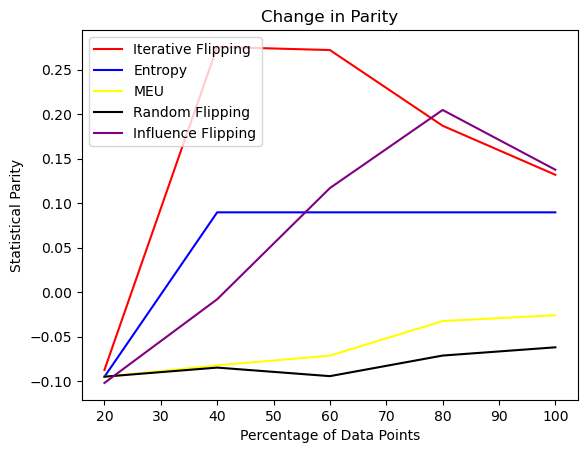

In [85]:
# Calculate the total number of data points
datapoints_iterative = len(ranked_greedy_parity_list)
datapoints_entropy = len(ranked_ent_parity_list)
datapoints_meu = len(meu_ranked_parity_list)
datapoints_random = len(random_flip_parity)
datapoints_influence = len(flip_parity_abs)

# Calculate the indices for the 5 points
indices_iterative = [int(i * datapoints_iterative / 5) for i in range(0, 5)]
indices_entropy = [int(i * datapoints_entropy / 5) for i in range(0, 5)]
indices_meu = [int(i * datapoints_meu / 5) for i in range(0, 5)]
indices_random = [int(i * datapoints_random / 5) for i in range(0, 5)]
indices_influence = [int(i * datapoints_influence / 5) for i in range(0, 5)]

# Extract the values at these indices
values_iterative = [ranked_greedy_parity_list[index] for index in indices_iterative]
values_entropy = [ranked_ent_parity_list[index] for index in indices_entropy]
values_meu = [meu_ranked_parity_list[index] for index in indices_meu]
values_random = [random_flip_parity[index] for index in indices_random]
values_influence = [flip_parity_abs[index] for index in indices_influence]

# Plot the values
plt.plot([20, 40, 60, 80, 100], values_iterative, label='Iterative Flipping', color='Red')
plt.plot([20, 40, 60, 80, 100], values_entropy, label='Entropy', color='Blue')
plt.plot([20, 40, 60, 80, 100], values_meu, label='MEU', color='Yellow')
plt.plot([20, 40, 60, 80, 100], values_random, label='Random Flipping', color='Black')
plt.plot([20, 40, 60, 80, 100], values_influence, label='Influence Flipping', color='Purple')

# Add labels and legend
plt.xlabel('Percentage of Data Points')
plt.ylabel('Statistical Parity')
plt.title('Change in Parity')
plt.legend()